In [1]:
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/rm1000/lung-cancer-histopathological-images"
from google.colab import drive
import os

# mount drive
drive.mount('/content/drive', force_remount=True)

basedir = "/content/drive/MyDrive/Colab Notebooks/visualintelligence/CNN/"
#basedir = "" # for local execution
datasetdir = "/content/drive/MyDrive/Colab Notebooks/visualintelligence/"

# install requirements in the parent folder
requirements_path = "'/content/drive/MyDrive/Colab Notebooks/visualintelligence/requirements.txt'"
!pip install -r {requirements_path}

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.io.image import decode_jpeg, read_file
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
from sklearn.model_selection import StratifiedKFold
import random
from PIL import Image
import torch.multiprocessing as mp
from functools import lru_cache
from torchvision.io import read_image, ImageReadMode
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from collections import OrderedDict
from functools import lru_cache
from tqdm.auto import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from zipfile import ZipFile
from functools import lru_cache
import json
import torch
from torch.cuda.amp import autocast, GradScaler

In [3]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

import multiprocessing

num_cores = min(multiprocessing.cpu_count(), 4)
print(f"Number of cores: {num_cores}")

Using cuda
Number of cores: 2


In [4]:
ADENOCARCINOMA = "adenocarcinoma"
SQUAMOUS_CELL_CARCINOMA = "squamous_cell_carcinoma"
BENIGN = "benign"

class_0 = BENIGN
class_1 = ADENOCARCINOMA

In [5]:
#with ZipFile(datasetdir + "dataset.zip", "r") as zip_ref:
#    zip_ref.extractall()
#
## move folders to the right place
#os.makedirs("dataset", exist_ok=True)
#shutil.move(ADENOCARCINOMA, "dataset")
#shutil.move(SQUAMOUS_CELL_CARCINOMA, "dataset")
#shutil.move(BENIGN, "dataset")

Number of files in benign folder: 5000
Number of files in adenocarcinoma folder: 5000
   filename   class
0  0448.jpg  benign
1  3487.jpg  benign
2  4807.jpg  benign
3  3795.jpg  benign
4  3468.jpg  benign


Text(0.5, 1.0, 'Class distribution')

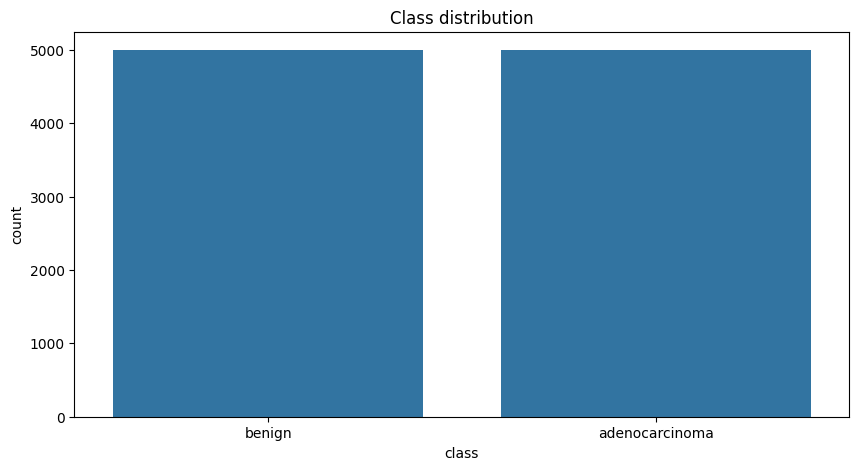

In [6]:
# Creating lists for dataframe construction
allFilesClass0 = os.listdir(f"dataset/{class_0}")
allFilesClass1 = os.listdir(f"dataset/{class_1}")

print(f"Number of files in {class_0} folder: {len(allFilesClass0)}")
print(f"Number of files in {class_1} folder: {len(allFilesClass1)}")

df = pd.DataFrame(columns=["filename", "class"])
df["filename"] = allFilesClass0 + allFilesClass1
df["class"] = [class_0] * len(allFilesClass0) + [class_1] * len(allFilesClass1)

# Displaying the dataframe
print(df.head())

# Displaying the class distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="class")
plt.title("Class distribution")

In [7]:
# Performing a stratified k-folds subdivision
KFOLDS = 10
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)
skf.get_n_splits(df["filename"], df["class"])

# Storing indexes to reuse them later
train_indexes = []
val_indexes = []
for train_index, val_index in skf.split(df["filename"], df["class"]):
    train_indexes.append(train_index)
    val_indexes.append(val_index)

train_splits = pd.DataFrame(columns=[f"train_{i}" for i in range(KFOLDS)])
val_splits = pd.DataFrame(columns=[f"val_{i}" for i in range(KFOLDS)])

for i in range(KFOLDS):
    train_splits[f"train_{i}"] = train_indexes[i]
    val_splits[f"val_{i}"] = val_indexes[i]

# Saving the splits
train_splits.to_csv(basedir + "train_splits.csv", index=False)
val_splits.to_csv(basedir + "val_splits.csv", index=False)

In [8]:
# recover the splits
train_splits = pd.read_csv(basedir + "train_splits.csv")
val_splits = pd.read_csv(basedir + "val_splits.csv")

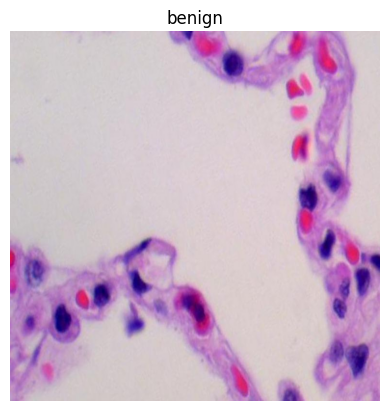

Image size: (768, 768)
Image mode: RGB


In [9]:
# image inspection

random.seed(42)
idx = random.choice(range(len(df)))
image = Image.open(f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
plt.imshow(image)


plt.title(df.iloc[idx]["class"])
plt.axis("off")
plt.show()

# print metadata
print(f"Image size: {image.size}")
print(f"Image mode: {image.mode}")

In [10]:
# Finding all the unique shapes of the images inside the dataset
#shapes = []
#for idx in tqdm(range(len(df))):
#    image = Image.open(f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
#    shapes.append(image.size)
#
#shapes = np.array(shapes)
#unique_shapes = np.unique(shapes, axis=0)
#print(f"Unique shapes: {unique_shapes}") # 768x768

In [11]:
class LungCancerDataset(Dataset):
    def __init__(self, df, folder_path, transform=None, cache_size=2000):
        self.df = df
        self.folder_path = folder_path
        self.transform = transform
        self.cache_size = cache_size
        self.cache = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if idx in self.cache:
            image, label = self.cache[idx]
        else:
            img_name = self.df.iloc[idx]["filename"]
            img_class = self.df.iloc[idx]["class"]
            img_path = os.path.join(self.folder_path, img_class, img_name)

            # Load and cache image
            # image = Image.open(img_path).convert("RGB")
            # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255
            data = read_file(img_path)
            image = decode_jpeg(data, device=device).half() / 255
            label = 1 if img_class == class_1 else 0
            label = torch.tensor(label, dtype=torch.long)

            # Add to cache
            if len(self.cache) < self.cache_size:
                self.cache[idx] = (image, label)

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
TARGET_IMAGE_SIZE = 30

In [13]:
def resize_dataset(df, size):
    new_folder = "dataset_resized"
    os.makedirs(new_folder, exist_ok=True)
    for idx in tqdm(range(len(df))):
        img_path = f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
        image = Image.open(img_path)
        image = image.resize(size)
        dest_path = f"{new_folder}/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}"
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        image.save(dest_path)

resize_dataset(df, (TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
def calculate_fold_stats(df, train_idx, image_size=TARGET_IMAGE_SIZE):
    """Calculate mean and std for a specific fold"""
    print(f"Calculating dataset statistics for fold {train_idx}")
    print(f"Number of images: {len(train_idx)}")
    transform = transforms.Compose(
        [transforms.Resize((image_size, image_size))]
    )

    # Create dataset for train fold
    train_df = df.iloc[train_idx]
    train_dataset = LungCancerDataset(train_df, "dataset_resized", transform=transform)

    # Calculate mean and std
    channels_sum = torch.zeros(3, device=device)
    channels_squared_sum = torch.zeros(3, device=device)
    num_batches = 0

    for data, _ in tqdm(
        DataLoader(
            train_dataset,
            batch_size=128,
        ),
        desc="Calculating dataset statistics",
    ):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [15]:
def create_dataloaders(
    df, train_idx, val_idx, mean, std, batch_size=128, image_size=TARGET_IMAGE_SIZE
):
    """Create normalized dataloaders for a specific fold"""

    # Define transforms
    train_transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    val_transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.Normalize(mean=mean, std=std),
        ]
    )

    # Create datasets
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_dataset = LungCancerDataset(train_df, "dataset_resized", transform=train_transform)
    val_dataset = LungCancerDataset(val_df, "dataset_resized", transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [16]:
# Computing stats
fold_stats = {}
for fold in range(KFOLDS):
    print(f"Processing fold {fold}")
    train_idx = train_splits[f"train_{fold}"].values
    val_idx = val_splits[f"val_{fold}"].values

    # Calculate statistics for this fold
    mean, std = calculate_fold_stats(df, train_idx)
    fold_stats[fold] = {"mean": mean, "std": std}

    # Create dataloaders with fold-specific normalization
    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

    # Print fold statistics
    print(f"Fold {fold} statistics:")
    print(f"Mean: {mean}")
    print(f"Std: {std}\n")

# Save fold statistics
with open("fold_stats.json", "w") as f:
    json.dump(
        {
            k: {"mean": v["mean"].tolist(), "std": v["std"].tolist()}
            for k, v in fold_stats.items()
        },
        f,
    )

Processing fold 0
Calculating dataset statistics for fold [   0    1    2 ... 9997 9998 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 0 statistics:
Mean: tensor([0.7041, 0.5700, 0.8274], device='cuda:0')
Std: tensor([0.1598, 0.1713, 0.1319], device='cuda:0')

Processing fold 1
Calculating dataset statistics for fold [   0    1    2 ... 9996 9997 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 1 statistics:
Mean: tensor([0.7040, 0.5698, 0.8275], device='cuda:0')
Std: tensor([0.1599, 0.1713, 0.1319], device='cuda:0')

Processing fold 2
Calculating dataset statistics for fold [   0    1    2 ... 9997 9998 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 2 statistics:
Mean: tensor([0.7045, 0.5698, 0.8271], device='cuda:0')
Std: tensor([0.1598, 0.1713, 0.1322], device='cuda:0')

Processing fold 3
Calculating dataset statistics for fold [   1    2    3 ... 9997 9998 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 3 statistics:
Mean: tensor([0.7039, 0.5695, 0.8271], device='cuda:0')
Std: tensor([0.1601, 0.1714, 0.1319], device='cuda:0')

Processing fold 4
Calculating dataset statistics for fold [   0    1    2 ... 9997 9998 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 4 statistics:
Mean: tensor([0.7042, 0.5699, 0.8275], device='cuda:0')
Std: tensor([0.1599, 0.1715, 0.1318], device='cuda:0')

Processing fold 5
Calculating dataset statistics for fold [   0    3    4 ... 9997 9998 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 5 statistics:
Mean: tensor([0.7039, 0.5695, 0.8273], device='cuda:0')
Std: tensor([0.1596, 0.1713, 0.1316], device='cuda:0')

Processing fold 6
Calculating dataset statistics for fold [   0    1    2 ... 9996 9997 9998]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 6 statistics:
Mean: tensor([0.7039, 0.5694, 0.8272], device='cuda:0')
Std: tensor([0.1600, 0.1712, 0.1320], device='cuda:0')

Processing fold 7
Calculating dataset statistics for fold [   0    1    2 ... 9997 9998 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 7 statistics:
Mean: tensor([0.7040, 0.5696, 0.8274], device='cuda:0')
Std: tensor([0.1600, 0.1714, 0.1320], device='cuda:0')

Processing fold 8
Calculating dataset statistics for fold [   0    1    2 ... 9996 9998 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 8 statistics:
Mean: tensor([0.7041, 0.5698, 0.8273], device='cuda:0')
Std: tensor([0.1601, 0.1714, 0.1318], device='cuda:0')

Processing fold 9
Calculating dataset statistics for fold [   0    1    2 ... 9997 9998 9999]
Number of images: 9000


Calculating dataset statistics:   0%|          | 0/71 [00:00<?, ?it/s]

Fold 9 statistics:
Mean: tensor([0.7038, 0.5693, 0.8273], device='cuda:0')
Std: tensor([0.1600, 0.1715, 0.1322], device='cuda:0')



In [17]:
# load fold statistics
with open(basedir + "fold_stats.json", "r") as f:
    fold_stats = json.load(f)
print(fold_stats)

{'0': {'mean': [0.7064047455787659, 0.5720739960670471, 0.8341714143753052], 'std': [0.1673128455877304, 0.20926183462142944, 0.11783168464899063]}, '1': {'mean': [0.7064012885093689, 0.5720331072807312, 0.8340111970901489], 'std': [0.1673007309436798, 0.20920173823833466, 0.11779171973466873]}, '2': {'mean': [0.7062825560569763, 0.5720421671867371, 0.834133505821228], 'std': [0.167218416929245, 0.20908495783805847, 0.11773984134197235]}, '3': {'mean': [0.7064064145088196, 0.5721913576126099, 0.8341804146766663], 'std': [0.16709156334400177, 0.20918165147304535, 0.11760079115629196]}, '4': {'mean': [0.7066220641136169, 0.5721625685691833, 0.8340489268302917], 'std': [0.1670798808336258, 0.20912280678749084, 0.11775249242782593]}, '5': {'mean': [0.7067297101020813, 0.5721986889839172, 0.8341744542121887], 'std': [0.16703304648399353, 0.20902416110038757, 0.11764462292194366]}, '6': {'mean': [0.7062463760375977, 0.5719467401504517, 0.8339688181877136], 'std': [0.16714131832122803, 0.2091

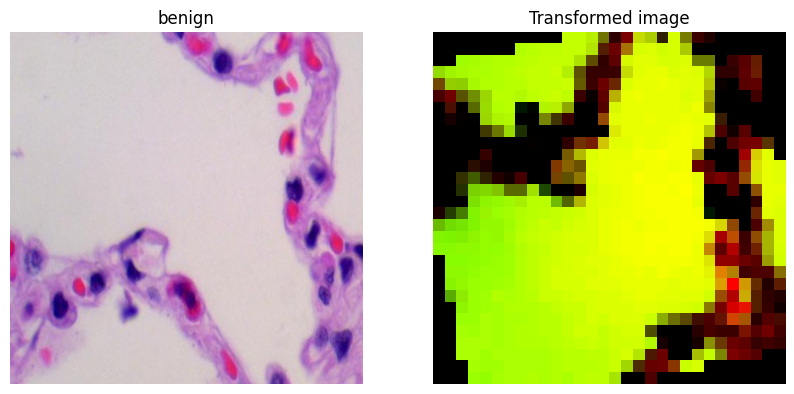

In [18]:
# Display a random image from the dataset
random.seed(42)
idx = random.choice(range(len(df)))
image = Image.open(f"dataset/{df.iloc[idx]['class']}/{df.iloc[idx]['filename']}")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title(df.iloc[idx]["class"])
ax[0].axis("off")

# Display the image after applying the transforms
transform = transforms.Compose(
    [
        transforms.Resize((TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize(mean=fold_stats["0"]["mean"], std=fold_stats["0"]["std"]),
    ]
)

transformed_image = transform(image)
transformed_image = transformed_image.permute(1, 2, 0)

ax[1].imshow(transformed_image)
ax[1].set_title("Transformed image")
ax[1].axis("off")
plt.show()

In [19]:
# take the data from the first fold
train_idx = train_splits["train_0"].values
val_idx = val_splits["val_0"].values
mean = fold_stats["0"]["mean"]
std = fold_stats["0"]["std"]

# Create dataloaders with fold-specific normalization
train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

# check len of train and val loaders
print(f"Train loader length: {len(train_loader)}")
print(f"Val loader length: {len(val_loader)}")

Train loader length: 71
Val loader length: 8


In [20]:
# benchmark the dataloaders
#def benchmark_dataloader(loader, num_epochs=1):
#    for epoch in range(num_epochs):
#        for i, (data, target) in enumerate(tqdm(loader, desc=f"Epoch {epoch}")):
#            pass
#
#
#benchmark_dataloader(train_loader, num_epochs=1)
#benchmark_dataloader(val_loader, num_epochs=1)

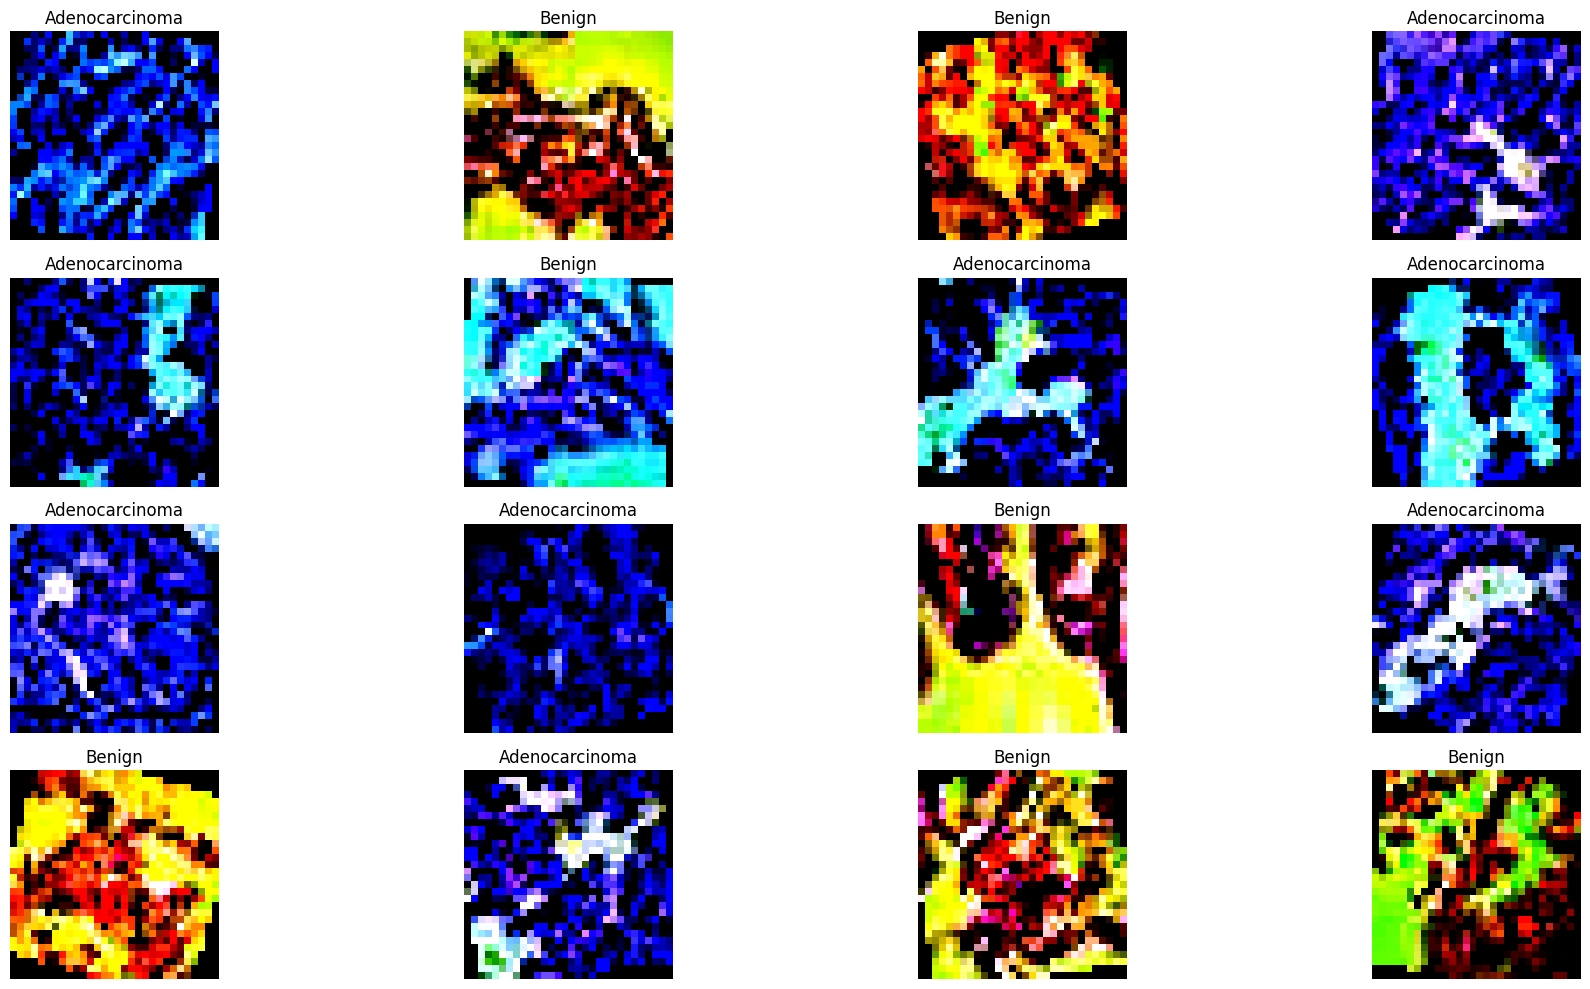

In [21]:
# show the content of the first batch
for i_batch, (images, labels) in enumerate(train_loader):
    fig, axes = plt.subplots(4, 4, figsize=(20, 10))
    for i, ax in enumerate(axes.flatten()):
        img = images[i].permute(1, 2, 0).to("cpu").float()
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
        ax.set_title("Adenocarcinoma" if labels[i] == 1 else "Benign")
    plt.tight_layout()
    plt.show()
    break

In [22]:
# Create a simple CNN model
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 4, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.Dropout(0.2),
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4, 2),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Instantiate model
model = ImageClassifier().to(device)

In [23]:
# getting a single image from the batch
images, labels = next(iter(train_loader))
print(f"Labels : {labels}")

print(f"Images shape: {images.shape}")
image = images[0].unsqueeze(0).to(device)
label = labels[0].unsqueeze(0).to(device)

# Forward pass
model.eval()
with torch.inference_mode():
    output = model(image.float())
    print(output)

# check the model summary
print(
    summary(
        model, input_size=(1, 3, TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE), device=device
    )
)

Labels : tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 1, 0])
Images shape: torch.Size([128, 3, 30, 30])
tensor([[-0.5170, -0.3544]], device='cuda:0')
Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 4, 15, 15]            --
│    └─Conv2d: 2-1                       [1, 4, 15, 15]            304
│    └─ReLU: 2-2                         [1, 4, 15, 15]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 15, 15]            8
│    └─Dropout: 2-4                      [1,

In [24]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
    on_trace_ready=torch.profiler.tensorboard_trace_handler("profile"),
) as prof:
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images.float())
        loss = F.cross_entropy(output, labels)
        loss.backward()
        prof.step()
        if prof.step_num == 40:
            break

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
print("Profiling finished.")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        34.30%     530.048ms        99.08%        1.531s     510.308ms       0.000us         0.00%      74.927ms      24.976ms             3  
                                       cudaLaunchKernel        11.06%     170.836ms        11.06%     170.836ms      14.049us       0.000us         0.00%       0.000us       0.000us         12160  
         

In [25]:
# Defining the operations to do in a training step
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scaler: GradScaler,
):

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through DataLoader batches
    for _, (img, label) in enumerate(dataloader):
        # Send data to target device
        X = img.to(device)
        y = label.to(device)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Automatic mixed precision training
        with autocast():
            # Forward pass
            y_pred = model(X)
            # Calculate loss
            loss = loss_fn(y_pred, y)

        # Scale loss and compute gradients
        scaler.scale(loss).backward()
        # Optimize step with scaler
        scaler.step(optimizer)
        scaler.update()

        # Accumulate loss
        train_loss += loss.item()

        # Calculate and accumulate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics for average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [26]:
def val_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for _, (img, label) in enumerate(dataloader):
            X = img.to(device)
            y = label.to(device)

            with autocast():
                val_pred_logits = model(X)
                loss = loss_fn(val_pred_logits, y)

            val_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += (val_pred_labels == y).sum().item() / len(val_pred_labels)

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [27]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 50,
    split: int = 0,
    patience: int = 5,
    min_delta: float = 0.001,
):
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Initialize early stopping variables
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=3, verbose="True"
    )

    # Initialize gradient scaler
    scaler = torch.amp.GradScaler(device=device)

    # Initialize tracking for best model
    best_val = 0

    # Training loop
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            scaler=scaler,
        )

        val_loss, val_acc = val_step(
            model=model, dataloader=val_dataloader, loss_fn=loss_fn
        )

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Save best model
        if val_acc > best_val:
            best_val = val_acc
            checkpoint = {
                "model": ImageClassifier(),
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            checkpoint_name = basedir + "checkpoint_" + str(split) + ".pth"
            torch.save(checkpoint, checkpoint_name)

        # Print training progress
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return results

In [ ]:
## These lines take a lot of time; you will load the trained model in the following

# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set hyperparameters
NUM_EPOCHS = 50
PATIENCE = 5
MIN_DELTA = 0.001

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# model = model.to(device)

# Train model with early stopping and LR scheduling
model_results = train(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    split=0,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-25-f5bfcd43fc18>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-26-25efa4ceb337>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch: 1 | train_loss: 0.3850 | train_acc: 0.9076 | val_loss: 0.2130 | val_acc: 0.9715
Epoch: 2 | train_loss: 0.2622 | train_acc: 0.9363 | val_loss: 0.1530 | val_acc: 0.9715
Epoch: 3 | train_loss: 0.2237 | train_acc: 0.9327 | val_loss: 0.1266 | val_acc: 0.9693
Epoch: 4 | train_loss: 0.1973 | train_acc: 0.9331 | val_loss: 0.1089 | val_acc: 0.9659


In [ ]:
## These are the results from the previous step; you will load the results in the following

# Extract train and validation loss and accuracy at each epoch
results = dict(list(model_results.items()))

# Get the loss values of the results dictionary (training and validation)
train_loss = results["train_loss"]
val_loss = results["val_loss"]

# Get the accuracy values of the results dictionary (training and validation)
train_acc = results["train_acc"]
val_acc = results["val_acc"]

# Figure out how many epochs there were
epochs = range(len(results["train_loss"]))
print("epochs: ", epochs)

In [ ]:
## Save results in a csv
results_df = pd.DataFrame(
    columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
)
results_df["train_loss"] = train_loss
results_df["val_loss"] = val_loss
results_df["train_acc"] = train_acc
results_df["val_acc"] = val_acc
results_df["epochs"] = epochs
results_df_name = basedir + "results_df_" + str(0) + ".csv"
results_df.to_csv(results_df_name)

print("df: ", results_df)

In [ ]:
results_from_csv = pd.read_csv(basedir + "results_df_0.csv")

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(results_from_csv["epochs"], results_from_csv["train_loss"], label="train_loss")
plt.plot(results_from_csv["epochs"], results_from_csv["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(
    results_from_csv["epochs"], results_from_csv["train_acc"], label="train_accuracy"
)
plt.plot(results_from_csv["epochs"], results_from_csv["val_acc"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
## You can find the model and result corresponding to each fold in the files inside the directory

# Continue the training and validation of the model for all the other folds
for i in range(1, 10):
    # Keeping the split
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]

    # Create dataloaders with fold-specific normalization
    train_loader, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)

    # Start the timer
    from timeit import default_timer as timer

    start_time = timer()
    # Train model
    model_results = train(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=NUM_EPOCHS,
        split=i,
    )
    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")
    # Extract train and validation loss and accuracy at each epoch
    results = dict(list(model_results.items()))
    # Get the loss values of the results dictionary (training and validation)
    train_loss = results["train_loss"]
    val_loss = results["val_loss"]
    # Get the accuracy values of the results dictionary (training and validation)
    train_acc = results["train_acc"]
    val_acc = results["val_acc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Save results in a csv
    results_df = pd.DataFrame(
        columns=["train_loss", "val_loss", "train_acc", "val_acc", "epochs"]
    )
    results_df["train_loss"] = train_loss
    results_df["val_loss"] = val_loss
    results_df["train_acc"] = train_acc
    results_df["val_acc"] = val_acc
    results_df["epochs"] = epochs
    results_df_name = basedir + "results_df_" + str(i) + ".csv"
    results_df.to_csv(results_df_name)

In [ ]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device(device))
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model

In [ ]:
def f1_score(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Avoid division by zero
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) != 0
        else 0
    )
    return f1


def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy


def compute_metrics(model, dataloader):
    model.eval()
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            y_pred = np.concatenate((y_pred, y_pred_class.cpu().numpy()))

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, f1


accuracies = []
f1_scores = []
# Iterate through all folds (0-9)
for i in range(10):
    model = load_checkpoint(basedir + "checkpoint_" + str(i) + ".pth")
    train_str = "train_" + str(i)
    val_str = "val_" + str(i)
    train_idx = train_splits[train_str].values
    val_idx = val_splits[val_str].values
    mean = fold_stats[str(i)]["mean"]
    std = fold_stats[str(i)]["std"]
    _, val_loader = create_dataloaders(df, train_idx, val_idx, mean, std)
    accuracy, f1 = compute_metrics(model, val_loader)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    print(f"Accuracy for split {i}: {accuracy}")
    print(f"F1 Score for split {i}: {f1}")


mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean F1 Score: {mean_f1_score}")